In [81]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [82]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [83]:
# Read the data
data = pd.read_csv("dataset_extremist - Sheet1 (1).csv")
data

,comments,extremist
0,"সমাবেশ করতে দেওয়াই উচিত না, গ্রেনেড মারা দলকে",yes
1,"সমাবেশ নয়াপল্টনেই হবে,,পুলিশ বাধা দিলে পুলিশকে...",yes
2,"আমি আমার ভোট দিব, এ অধিকার ফিরে পেতে চাই",no
3,মুক্তিকামী মানুষের জয় হবে ইনশাআল্লাহ,no
4,আগে বড়লোকেরা সম্মান কামানোর জন্য রাজনীতিতে আস...,no
...,...,...
4994,সাধারণ মানুষের আতংকের নাম বিএনপি।,yes
4995,দূর্নীতির বরপুত্র তারেক রহমানের নির্দেশে নৈরাজ...,yes
4996,সন্ত্রাসী কর্মকান্ডে বিএনপি বিশ্বের সব গুলো সন...,yes
4997,জনগন ভোট চোরদের পছন্দ করে.,yes


In [84]:
data = data[['comments','extremist']]

In [85]:
data

,comments,extremist
0,"সমাবেশ করতে দেওয়াই উচিত না, গ্রেনেড মারা দলকে",yes
1,"সমাবেশ নয়াপল্টনেই হবে,,পুলিশ বাধা দিলে পুলিশকে...",yes
2,"আমি আমার ভোট দিব, এ অধিকার ফিরে পেতে চাই",no
3,মুক্তিকামী মানুষের জয় হবে ইনশাআল্লাহ,no
4,আগে বড়লোকেরা সম্মান কামানোর জন্য রাজনীতিতে আস...,no
...,...,...
4994,সাধারণ মানুষের আতংকের নাম বিএনপি।,yes
4995,দূর্নীতির বরপুত্র তারেক রহমানের নির্দেশে নৈরাজ...,yes
4996,সন্ত্রাসী কর্মকান্ডে বিএনপি বিশ্বের সব গুলো সন...,yes
4997,জনগন ভোট চোরদের পছন্দ করে.,yes


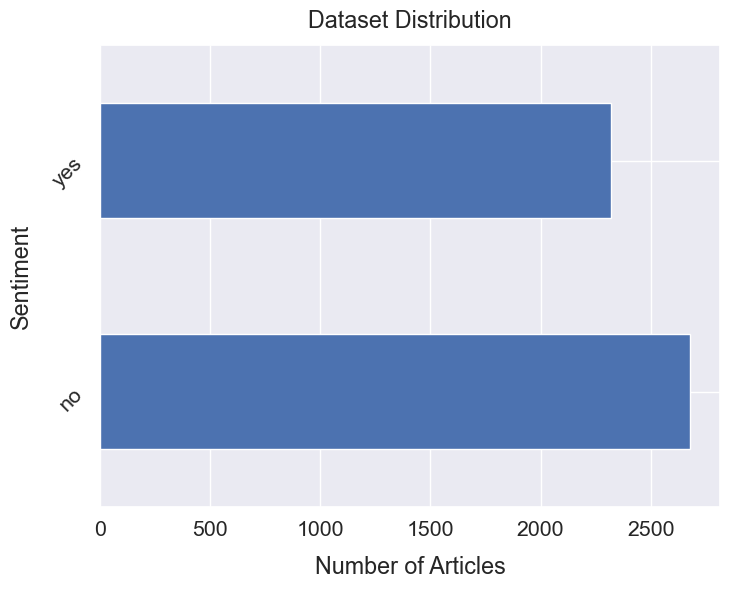

In [86]:
# Plot the Class distribution
sns.set(font_scale=1.4)
data['extremist'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of Articles", labelpad=12)
plt.ylabel("Sentiment", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [87]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
    news = articles.replace('\n',' ')
    news = re.sub('[^\u0980-\u09FF]',' ',str(news)) #removing unnecessary punctuation
    # stopwords removal
    stp = open('bangla_stopwords.txt','r',encoding="utf8").read().split()
    result = news.split()
    news = [word.strip() for word in result]
    news =" ".join(news)
    return news

In [88]:
# Apply the function into the dataframe
data['cleaned'] = data['comments'].apply(cleaning_documents)

In [89]:
data.head()

,comments,extremist,cleaned
0,"সমাবেশ করতে দেওয়াই উচিত না, গ্রেনেড মারা দলকে",yes,সমাবেশ করতে দেওয়াই উচিত না গ্রেনেড মারা দলকে
1,"সমাবেশ নয়াপল্টনেই হবে,,পুলিশ বাধা দিলে পুলিশকে...",yes,সমাবেশ নয়াপল্টনেই হবে পুলিশ বাধা দিলে পুলিশকে ...
2,"আমি আমার ভোট দিব, এ অধিকার ফিরে পেতে চাই",no,আমি আমার ভোট দিব এ অধিকার ফিরে পেতে চাই
3,মুক্তিকামী মানুষের জয় হবে ইনশাআল্লাহ,no,মুক্তিকামী মানুষের জয় হবে ইনশাআল্লাহ
4,আগে বড়লোকেরা সম্মান কামানোর জন্য রাজনীতিতে আস...,no,আগে বড়লোকেরা সম্মান কামানোর জন্য রাজনীতিতে আস...


In [90]:
words = [i.split() for i in data['cleaned']]


In [91]:
unique = []
for i in words:
    unique.extend(i)
len(unique)


44267

In [92]:
unique = list(set(unique))

In [93]:
len(unique)

8361

In [94]:
# Calculate the Length of each Document
data['Length'] = data.cleaned.apply(lambda x:len(x.split()))

# Remove the Documents with least words
dataset = data.loc[data.Length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Documents".format(len(data)-len(dataset)),
      "\nTotal Remaining Documents:",len(dataset))

After Cleaning: 
Removed 0 Small Documents 
Total Remaining Documents: 4999


In [95]:
dataset

,comments,extremist,cleaned,Length
0,"সমাবেশ করতে দেওয়াই উচিত না, গ্রেনেড মারা দলকে",yes,সমাবেশ করতে দেওয়াই উচিত না গ্রেনেড মারা দলকে,8
1,"সমাবেশ নয়াপল্টনেই হবে,,পুলিশ বাধা দিলে পুলিশকে...",yes,সমাবেশ নয়াপল্টনেই হবে পুলিশ বাধা দিলে পুলিশকে ...,12
2,"আমি আমার ভোট দিব, এ অধিকার ফিরে পেতে চাই",no,আমি আমার ভোট দিব এ অধিকার ফিরে পেতে চাই,9
3,মুক্তিকামী মানুষের জয় হবে ইনশাআল্লাহ,no,মুক্তিকামী মানুষের জয় হবে ইনশাআল্লাহ,5
4,আগে বড়লোকেরা সম্মান কামানোর জন্য রাজনীতিতে আস...,no,আগে বড়লোকেরা সম্মান কামানোর জন্য রাজনীতিতে আস...,14
...,...,...,...,...
4994,সাধারণ মানুষের আতংকের নাম বিএনপি।,yes,সাধারণ মানুষের আতংকের নাম বিএনপি,5
4995,দূর্নীতির বরপুত্র তারেক রহমানের নির্দেশে নৈরাজ...,yes,দূর্নীতির বরপুত্র তারেক রহমানের নির্দেশে নৈরাজ...,7
4996,সন্ত্রাসী কর্মকান্ডে বিএনপি বিশ্বের সব গুলো সন...,yes,সন্ত্রাসী কর্মকান্ডে বিএনপি বিশ্বের সব গুলো সন...,10
4997,জনগন ভোট চোরদের পছন্দ করে.,yes,জনগন ভোট চোরদের পছন্দ করে,5


In [96]:
# Save the Cleaned data for reuse
dataset.to_csv('cleaned_data2.csv')

In [97]:
# Load the Cleaned News
dataset = pd.read_csv('cleaned_data2.csv')
dataset.columns

Index(['Unnamed: 0', 'comments', 'extremist', 'cleaned', 'Length'], dtype='object')

In [98]:
dataset.Length.max()

43

In [99]:
#Dataset Summary
def data_summary(dataset):
    documents = []
    words = []
    u_words = []
  #total_u_word = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
  # find class names
    class_label = [k for k,v in dataset.extremist.value_counts().to_dict().items()]
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.extremist==label].cleaned) for word in t.strip().split()]
        counts = dict()
    for word in word_list:
        counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list  
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
    documents.append(len(list(dataset[dataset.extremist==label].cleaned)))
    # Total Word per class
    words.append(len(word_list))
    # Unique words per class 
    u_words.append(len(np.unique(word_list)))
       
    print("\nClass Name : ",label)
    print("Number of Documents:{}".format(len(list(dataset[dataset.extremist==label].cleaned))))  
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Most Frequent Words:\n")
    for k,v in ordered[:10]:
        print("{}\t{}".format(k,v))
    return documents,words,u_words,class_label

# pass the whole dataset into the function

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  yes
Number of Documents:2319
Number of Words:20738
Number of Unique Words:5160
Most Frequent Words:

করে	324
না	303
বিএনপি	286
ভোট	204
আর	183
এই	178
হবে	124
দেশের	117
কি	116
ও	113


# test and validation data


In [100]:
X,X_test,y,y_test = train_test_split(dataset.cleaned,dataset.extremist,train_size = 0.9,test_size = 0.1,random_state =0)


In [101]:
X_test.to_csv('test_data.csv')

In [102]:
test_data = pd.read_csv('test_data.csv')

In [103]:
test_data.head()

,Unnamed: 0,cleaned
0,4585,আর বর্তমানে কারা জাতির নেতৃত্ব দিচ্ছে
1,1593,বিএনপি ও দুর্নীতি যেন একে অপরের সমার্থক
2,562,মন চাই বলতে কিন্তু লিখে প্রকাশ করতে পারিনা
3,825,এতদিন পর পচা গম কোথা থেকে বের হলো
4,3777,এদের জন্য যারা সত্যিকার ভাবে বিপদে পরে তাদের ক...


In [104]:
y_test.to_csv('test_dataY.csv')

In [105]:
test_dataY = pd.read_csv('test_dataY.csv')

In [106]:
test_dataY.head()

,Unnamed: 0,extremist
0,4585,yes
1,1593,yes
2,562,no
3,825,no
4,3777,yes


In [107]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,test_size = 0.2,random_state =0)


# ends here

In [108]:
#===========================================================
                   ################# Label Encoding Function ##################
                   #===========================================================
def label_encoding(dataset,bool):
    le = LabelEncoder()
    le.fit(dataset.extremist)
    encoded_labels = le.transform(dataset.extremist)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print(color.BOLD+"\n\t\t\t===== Label Encoding ====="+color.END,"\nClass Names:-->",le.classes_)
    return labels  

                   #===========================================================
                   ################# Dataset Splitting Function ###############
                   #=========================================================== 

def dataset_split(news,category):
    X,X_test,y,y_test = train_test_split(news,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"Feature Size :======>"+color.END,X_train.shape[1])
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",news.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0],
        "\n\tValidation\t\t",X_valid.shape[0])
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [109]:
def encoded_texts(dataset,padding_length,max_words):
    tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
  
    tokenizer.fit_on_texts(dataset.cleaned)
  #============================== Tokenizer Info =================================
    (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
    def tokenizer_info(mylist,bool):
        ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
        for w,c in ordered[:10]:
            print(w,"\t",c)
  #=============================== Print all the information =========================
    print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
    print("Words --> Counts:")
    tokenizer_info(word_counts,bool =True )
    print("\nWords --> Documents:")
    tokenizer_info(word_docs,bool =True )
    print("\nWords --> Index:")
    tokenizer_info(word_index,bool =True )    
    print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
    sequences = tokenizer.texts_to_sequences(dataset.cleaned)
    word_index = tokenizer.word_index
    print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))  
    print(dataset.cleaned[10],"\n",sequences[10]) 

  #==================================== Pad Sequences ============================== 
    corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
    print("\n\t\t\t====== Paded Sequences ======\n",dataset.cleaned[10],"\n",corpus[10])   

  #=================================     Label Encoding ================================
    labels = label_encoding(dataset,True)

   # save the tokenizer into a pickle file
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return corpus,labels
  
#call the function
num_words = 5000
corpus,labels = encoded_texts(dataset,
                                30,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)

			====== Tokenizer Info ======
Words --> Counts:
না 	 758
করে 	 543
বিএনপি 	 411
আর 	 352
কি 	 315
এই 	 309
কথা 	 294
ভোট 	 293
হবে 	 287
জন্য 	 267

Words --> Documents:
না 	 693
করে 	 502
বিএনপি 	 408
আর 	 338
এই 	 300
কি 	 298
কথা 	 278
ভোট 	 267
হবে 	 266
জন্য 	 241

Words --> Index:
নৈরাজ্যের 	 8362
বরপুত্র 	 8361
পূরণ 	 8360
আলোকিত 	 8359
কোনদিনই 	 8358
যনগী 	 8357
আওয়ামীলীগকেও 	 8356
জাতীয়তাবাদী 	 8355
পছন্দের 	 8354
বিষয়ে 	 8353

Total Documents --> 4999

			====== Encoded Sequences ====== 
Found 8362 unique tokens
দেশের সাধারণ মানুষের মনের কথা তুলে ধরার জন্য স্যারকে সালাম জানাই 
 [12, 132, 58, 339, 8, 354, 592, 11, 1824, 1825, 433]

			====== Paded Sequences ======
 দেশের সাধারণ মানুষের মনের কথা তুলে ধরার জন্য স্যারকে সালাম জানাই 
 [  12  132   58  339    8  354  592   11 1824 1825  433    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

			===== Label Encoding ===== 
Class Names:--> ['no' 'yes']

Shape of Encoded Corpus =====> (

In [110]:
#Call Dataset Validation
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(corpus,labels)

Feature Size :======> 30

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 4999 
	Training		 3599 
	Test			 500 
	Validation		 900


In [119]:
embedding_dimension = 128
input_length = 30
vocab_size = 9000
num_classes = 2
batch_size = 128
num_epochs = 7
accuracy_threshold = 0.97


class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
            print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
            self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = "Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 

                            ###############################     CNN network architecture ################
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dimension, input_length = input_length),
tf.keras.layers.Conv1D(128, 5, activation= 'relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.1)),
tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout = 0.1)),
tf.keras.layers.Dense(28, activation='relu'),
tf.keras.layers.Dense(14, activation='relu'),
keras.layers.Flatten(),
tf.keras.layers.Dense(num_classes , activation='softmax')])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(X_train,
    y_train,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    verbose =1)
    #callbacks = callback_list)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 128)           1152000   
                                                                 
 conv1d_6 (Conv1D)           (None, 26, 128)           82048     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 bidirectional_12 (Bidirecti  (None, 5, 128)           98816     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 5, 128)           98816     
 onal)                                                           
                                                      

In [120]:
sample_news = 'মেরে ফেল'
cleaned_news = cleaning_documents(sample_news)

#class_names = ['anger', 'happy', 'neutral', 'sad']
class_names = ['no' ,'yes']

#print(cleaned_news)
# load the saved tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
#print(len(loaded_tokenizer.word_index))
seq= loaded_tokenizer.texts_to_sequences([cleaned_news])
padded = pad_sequences(seq, value=0.0,padding='post', maxlen= 30 )
pred = model.predict(padded)
#print(pred) 
print(pred)
class_names[np.argmax(pred)]


1/1 [==============================] - 1s 1s/step
[[0.05955423 0.9404458 ]]


'yes'

In [121]:
# save the model
tf.keras.models.save_model(model, 'Extremmist_Detection.h5', save_format='h5')
#model.save('Document_Categorization.h5')

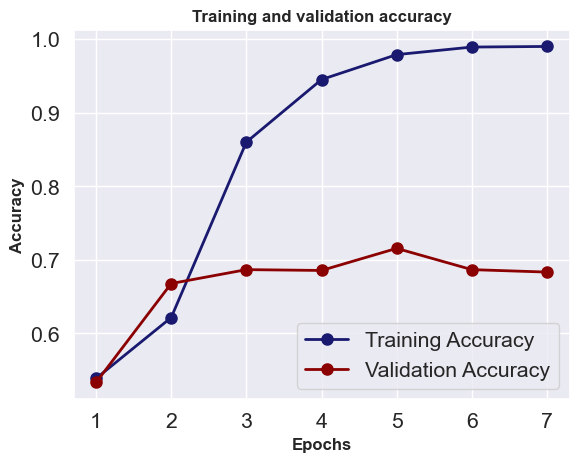

In [122]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')
                  #=========================================================
                  ############### Epochs vs Validation Accuracy Plot ##########
                  #==========================================================

plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training Accuracy','Validation Accuracy'])

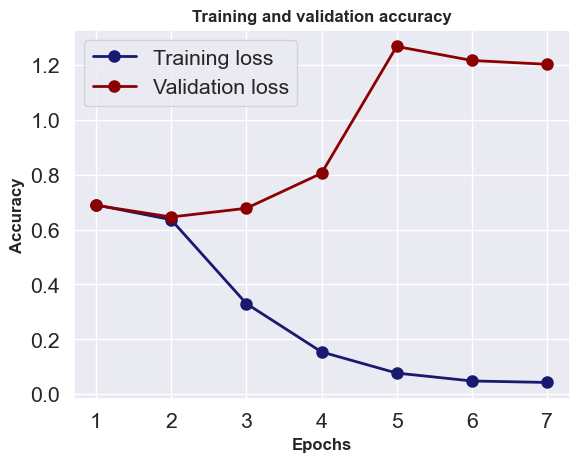

In [123]:
plt.plot(epochs, loss_values, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_loss_values, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training loss','Validation loss'])

In [124]:
# Load the saved model
model = load_model('Extremmist_Detection.h5')

In [125]:
#class_names = ['anger' ,'happy' ,'neutral', 'sad']
class_names = ['yes' ,'no']
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'no','1':'yes'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

16/16 [==============================] - 2s 11ms/step


,precision,recall,f1-score,support
no,87.60,83.27,85.38,263.00
yes,82.40,86.92,84.60,237.00
accuracy,85.00,85.00,85.00,0.85
macro avg,85.00,85.09,84.99,500.00
weighted avg,85.14,85.00,85.01,500.00


16/16 [==============================] - 0s 11ms/step


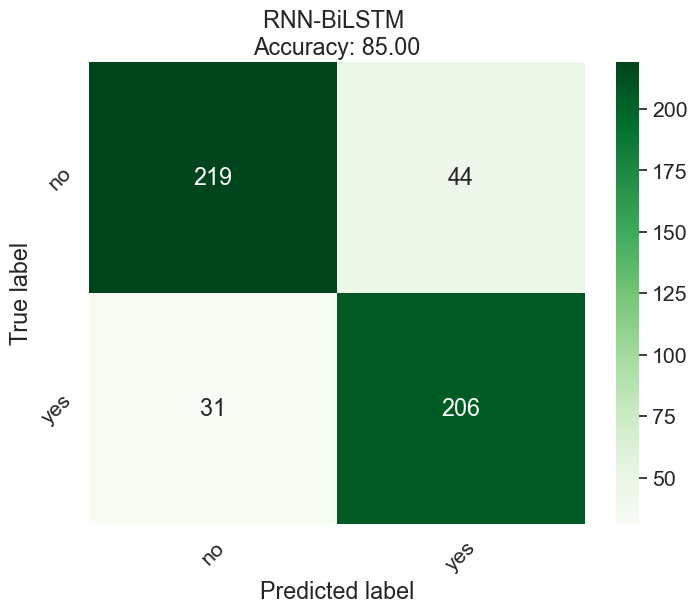

In [126]:
#Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, y_pred) 

class_names = ['no' ,'yes']
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens", fmt='g')
plt.title('RNN-BiLSTM \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [127]:
print(y_pred)

[1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1
 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1
 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0
 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1
 0 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1
 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1
 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0
 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0
 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0
 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 1 0 1 1 0 1 1 0 1 1 

In [128]:
y_pred_data = pd.DataFrame(y_pred, columns= ['y_pred'])

In [129]:
y_pred_data.to_csv('y_pred.csv')

In [130]:
y_pred_data.head()

,y_pred
0,1
1,1
2,0
3,0
4,1


In [131]:
print(y_test)

[1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1
 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0
 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1
 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0
 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0
 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1
 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0
 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0
 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0
 1 0 1 0 0 1 0 1 0 0 0 1 

In [132]:
y_test = pd.DataFrame(y_test, columns= ['y_test'])

In [133]:
y_test.to_csv('y_test.csv')

In [134]:
y_pred_data2 =  pd.concat([y_pred_data,y_test], axis=1)

In [135]:
y_pred_data2

,y_pred,y_test
0,1,1
1,1,1
2,0,0
3,0,0
4,1,1
...,...,...
495,1,0
496,1,0
497,1,1
498,0,0


In [136]:
with pd.option_context('display.max_rows', None,):
    print(y_pred_data2)

     y_pred  y_test
0         1       1
1         1       1
2         0       0
3         0       0
4         1       1
5         0       0
6         0       0
7         0       0
8         0       0
9         0       0
10        0       0
11        0       0
12        1       1
13        1       1
14        1       0
15        1       0
16        1       1
17        0       0
18        0       0
19        0       0
20        0       0
21        0       0
22        1       1
23        0       0
24        1       1
25        1       1
26        1       1
27        0       0
28        1       1
29        0       0
30        0       0
31        0       0
32        1       1
33        0       0
34        1       1
35        0       0
36        1       1
37        0       0
38        0       0
39        0       0
40        1       1
41        1       1
42        1       1
43        0       0
44        1       1
45        0       0
46        0       0
47        1       0
48        0       0
